# Statcast Data Preparation

**Author:** Joel Klein

**Date:** July 1, 2022

**Description:** This script loads in MLB statcast data from every MLB registered pitch in 2021 from starting pitchers and prepares the data for use in the starting pitcher scouting report. 

**Data:** The data is scraped from *baseballsavant.com* for 2021. The code for scraping the data and making the data available is called 00_statcast_data_download.ipynb in the code folder of this repository.

**Scope:** We will use MLB pitch data in 2021 for starting pitchers. We will filter the scope of pitchers in the data to be any pitcher who started a game in 2021 and threw more than 100 pitches.

**Summary:**

There are a series of data preparation steps in this notebook: 

* **Filter to only starting pitchers w/ over 100 pitches in 2021 season**
  * We are building scouting reports for MLB starting pitchers. So we will filter the data to only pitchers who started a game in 2021. 
  * We also do not want to include pitchers throwing under 100 pitches as the data is likely not reliable for identifying pitcher tendencies with that little data.

* **Filter to only the first 9 innings of pitches:**
  * There are very few games which enter extra innings so we will exclude extras from scope.

* **Filter rare pitch types:** 
    
  The pitch types in scope for this analysis are:
    - 4-Seam Fastball
    - Slider
    - 2-Seam Fastball
    - Changeup
    - Sinker
    - Curveball
    - Cutter
    - Knuckle Curve
    - Split-Finger

* **Input Feature Engineering:**
  * Create current pitch count feature - the pitch count impacts the types of pitches thrown
  * Create pitcher and hitter indicator statistics such as wOBA and whiff %
  * Create run differential between pitching and hitting team
  * Normalize pitch height based on batter height
  * Assign batted ball type to label
  * Reformat event
  * Calculate next pitch count

**Notes:** 

**Warnings:** 

**Outline:** 
  - Import Libraries
  - Global Options
  - Set Directories
  - Define Functions
  - Load Data
  - Data Filtering
  - Data Preparation
    - Feature Engineering
  

## Import Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd 
import os
import zipfile

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# image insertion
from IPython.display import Image
from IPython.core.display import HTML 

# pybaseball
import pybaseball as pyb
from pybaseball import playerid_reverse_lookup

## Global Options

In [2]:
# do not show warnings
import warnings
warnings.filterwarnings('ignore')

# set pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 2000)
pd.options.display.float_format = '{:.5f}'.format

## Set Directories

In [3]:
# set data directory
DATA_DIR = "C:/Users/13202/final-project-dataviz/data"

## Define Functions

In [4]:
# define a function for loading in dataset
def load_data(in_path, name):
    df = pd.read_csv(in_path, sep=';')
    print(f"{name}: shape is {df.shape}")
    return df

## Load Data

In [5]:
# set the input data set names we will load in
ds_name = "all_21_dataframe"

# load in each dataset
statcast_df = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

all_21_dataframe: shape is (709851, 93)


## Data Filtering

### Filtering out extra innings

There are games which can go into extra innings. We will remove any at-bats which occur in extra innings from the data as these events are not common in the MLB. 

In [6]:
##### Data Filtering to First 9 innings ----

# we are only going to predict the first 9 innings
statcast_df = statcast_df[statcast_df['inning'] <= 9.0]

### Filtering to only starting pitchers with greater than 100 pitches in 2021 season

We are only including pitchers who started an MLB game in 2021. 

There are many instances in major league baseball where relief pitchers start a game and receive at-bats and there is little pitch data. We will filter the data set to only include pitchers with over 100 pitches in the 2021 season.

In [7]:
##### Filter to only starting pitchers -----

# get at bat numbers of situations where there are 0 outs in the first inning
first_inning_ab_0_outs_df = statcast_df[(statcast_df['inning'] == 1) & (statcast_df['outs_when_up'] == 0)][['game_pk', 'inning_topbot', 'at_bat_number', 'pitcher']].drop_duplicates()

# get starting pitchers in 2021 by filtering previous data frame to only pitcher ids pitching first at bat of the game
starting_pitchers = first_inning_ab_0_outs_df[first_inning_ab_0_outs_df['at_bat_number'] == first_inning_ab_0_outs_df.groupby(['game_pk', 'inning_topbot'])['at_bat_number'].transform('min')]['pitcher'].unique()

# filter the data to only get starting pitchers
statcast_starting_pitcher_df = statcast_df[statcast_df["pitcher"].isin(starting_pitchers)]

# filter the data to only get starting pitchers who threw over 100 pitches in 2021 season
statcast_starting_pitcher_df = statcast_starting_pitcher_df[statcast_starting_pitcher_df.groupby(['pitcher'])['pitcher'].transform('count') >= 100]

The pitcher is listed as an id rather than by name. For the visualization layer, we want to map the pitcher id to pitcher name. 

In [8]:
##### Get pitcher name from pitcher id -----

# get a numpy array of pitcher names by looking up pitcher names with pybaseball
starting_pitchers_names = pd.Series([(playerid_reverse_lookup([i])['name_first'].str.capitalize() + ' ' +  playerid_reverse_lookup([i])['name_last'].str.capitalize())[0] for i in list(starting_pitchers)])

# get a reference table of the pitcher id and pitcher name
starting_pitcher_ref_df = pd.DataFrame({'pitcher': starting_pitchers, 'pitcher_name': starting_pitchers_names}, columns=['pitcher', 'pitcher_name'])

# get pitcher name from pitcher id
statcast_starting_pitcher_df = statcast_starting_pitcher_df.merge(starting_pitcher_ref_df, on='pitcher', how='left')

Gathering player lookup table. This may take a moment.


### Get Batter Names

In [9]:
# return unique batters
batters = statcast_starting_pitcher_df['batter'].unique()

# get a numpy array of batter names by looking up pitcher names with pybaseball
batters_names = pd.Series([(playerid_reverse_lookup([i])['name_first'].str.capitalize() + ' ' +  playerid_reverse_lookup([i])['name_last'].str.capitalize())[0] for i in list(batters)])

# get a reference table of the batter id and batter name
batters_ref_df = pd.DataFrame({'batter': batters, 'batter_name': batters_names}, columns=['batter', 'batter_name'])

# get pitcher name from pitcher id
statcast_starting_pitcher_df = statcast_starting_pitcher_df.merge(batters_ref_df, on='batter', how='left')

### Filtering rare pitch types

There are several pitch types in the data set. 

In [10]:
# Unique pitch types -- these will end up being our target class in the NN
statcast_df.pitch_type.unique()

array(['FF', 'SL', 'CU', 'SI', 'FS', 'FC', 'CH', 'KC', nan, 'FA', 'CS',
       'KN', 'EP', 'SC'], dtype=object)

Some of the pitch types in the raw data are very rare. We will only keep the commonly thrown pitch types in scope for the scouting report.

In [11]:
# Get a table of each pitch type's average movement in the X and Y directions, with velocity
pitch_type_count = statcast_starting_pitcher_df.groupby(by=["pitch_type"], as_index=False).agg(
    **{
       "Count": pd.NamedAgg(column="pitch_type", aggfunc='count'),
    }
)

print(pitch_type_count)

   pitch_type   Count
0          CH   60390
1          CS      46
2          CU   43512
3          EP       2
4          FA       9
5          FC   34695
6          FF  167056
7          FS    8061
8          KC   11581
9          SI   74993
10         SL   84251


Filter out rarely used pitch types -- CS, EP, FA

In [12]:
# filter out rare pitch types
statcast_starting_pitcher_df = statcast_starting_pitcher_df[~statcast_starting_pitcher_df['pitch_type'].isin(['CS', 'EP', 'FA'])]

## Feature Engineering

### Creating Count Feature

The pitch count impacts the types of pitches thrown. It is important to combine the balls and strikes into 1 feature as they are used together to determine the pitch type which will be thrown. There are also a hand full of instances in the data which have 4 balls for the current count. We will replace 4 balls with 3 balls. 

In [13]:
# there are some rows which have 4 balls for the count which is impossible
# we will fix those rows by replacing four balls with three
statcast_starting_pitcher_df["balls"][statcast_starting_pitcher_df["balls"] == 4] = 3

# Add count column to df
statcast_starting_pitcher_df["count"] = statcast_starting_pitcher_df["balls"].astype(int).astype(str) + "-" + statcast_starting_pitcher_df["strikes"].astype(int).astype(str)

# recategorize pitch counts into aggregate levels even, ahead, behind
statcast_starting_pitcher_df['count_advantage'] = np.where(statcast_starting_pitcher_df['count'].isin(['1-0', '2-1', '3-2']), 'Even',
                                                  np.where(statcast_starting_pitcher_df['count'].isin(['0-0', '0-1', '1-1']), 'Ahead (<2 strikes)', 
                                                  np.where(statcast_starting_pitcher_df['count'].isin(['0-2', '1-2', '2-2']), 'Ahead (2 strikes)',
                                                  np.where(statcast_starting_pitcher_df['count'].isin(['2-0', '3-0', '3-1']), 'Behind', 'NA'))))

### Modify the on base features

The on base features in the data in the original data represent player ids, when there is a runner on the base and NaN if there is not a runner on. We will transform this feature to be an indicator if there is a runner on the base as the runner likely doesn't affect the pitch type.

In [14]:
# change the on base fields to indicators
statcast_starting_pitcher_df['on_1b'] = np.where(statcast_starting_pitcher_df['on_1b'].isna(), 0, 1)
statcast_starting_pitcher_df['on_2b'] = np.where(statcast_starting_pitcher_df['on_2b'].isna(), 0, 1)
statcast_starting_pitcher_df['on_3b'] = np.where(statcast_starting_pitcher_df['on_3b'].isna(), 0, 1)

In [15]:
# create a category for runners on base
statcast_starting_pitcher_df['runners_on_base'] = np.where((statcast_starting_pitcher_df['on_1b'] == 0) & (statcast_starting_pitcher_df['on_2b'] == 0) & (statcast_starting_pitcher_df['on_3b'] == 0), 'Empty',
                                                  np.where((statcast_starting_pitcher_df['on_1b'] == 1) & (statcast_starting_pitcher_df['on_2b'] == 0) & (statcast_starting_pitcher_df['on_3b'] == 0), '1B',
                                                  np.where((statcast_starting_pitcher_df['on_1b'] == 0) & (statcast_starting_pitcher_df['on_2b'] == 1) & (statcast_starting_pitcher_df['on_3b'] == 0), '2B',
                                                  np.where((statcast_starting_pitcher_df['on_1b'] == 0) & (statcast_starting_pitcher_df['on_2b'] == 0) & (statcast_starting_pitcher_df['on_3b'] == 1), '3B',
                                                  np.where((statcast_starting_pitcher_df['on_1b'] == 1) & (statcast_starting_pitcher_df['on_2b'] == 1) & (statcast_starting_pitcher_df['on_3b'] == 0), '1B & 2B',
                                                  np.where((statcast_starting_pitcher_df['on_1b'] == 1) & (statcast_starting_pitcher_df['on_2b'] == 0) & (statcast_starting_pitcher_df['on_3b'] == 1), '1B & 3B',
                                                  np.where((statcast_starting_pitcher_df['on_1b'] == 0) & (statcast_starting_pitcher_df['on_2b'] == 1) & (statcast_starting_pitcher_df['on_3b'] == 1), '2B & 3B',
                                                  np.where((statcast_starting_pitcher_df['on_1b'] == 1) & (statcast_starting_pitcher_df['on_2b'] == 1) & (statcast_starting_pitcher_df['on_3b'] == 1), 'Bases Loaded', np.nan))))))))

### Pitcher statistics

We are looking to calculate the whiff percentage of certain pitch types for a pitcher in the scouting report. We will need to calculate a whiff indicator.

In [16]:
# create strike percentage feature
statcast_starting_pitcher_df['strike_ind'] = statcast_starting_pitcher_df['description'].isin(['called_strike', 'foul', 'foul_tip', 'swinging_strike', 'hit_into_play', 'hit_into_play', 'foul', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip'])

# create whiff percentage feature
statcast_starting_pitcher_df['whiff_ind'] = np.where(statcast_starting_pitcher_df['description'].isin(['swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 1, 
                                            np.where(statcast_starting_pitcher_df['description'].isin(['hit_into_play', 'foul', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip']), 0, np.nan))

Calculate the number of times the pitcher has faced that batter in the current game. Often, the pitcher will try not to throw too many of the same pitch class to the same batter, as there is a negative correlation with performance.

In [17]:
# calculate number of times the pitcher has faced that batter in the current game
statcast_starting_pitcher_df["tto"] = statcast_starting_pitcher_df.groupby(["game_pk", "pitcher", "batter"])["at_bat_number"].rank("dense", ascending=True)

### Run Differential

We will breakdown pitcher tendencies based on the score of the game. To simplify this feature, we will create a run differential feature for the pitcher.

In [18]:
# create run differential by subtracting the batting team's score from the pitching team's score
statcast_starting_pitcher_df['run_differential'] = statcast_starting_pitcher_df['fld_score'] - statcast_starting_pitcher_df['bat_score']

### Pitch Location Normalization

There are differing heights among batters which adjusts the strike zone and effects where pitchers will locate their pitches (see image below). 

We need to adjust the pitch height feature to be normalized to league average based on the top and bottom of the strike zone.

In [19]:
# view image comparing two batters with differing strike zone heights
Image(url= "http://www.fangraphs.com/blogs/wp-content/uploads/2017/10/altuve-bregman.png")

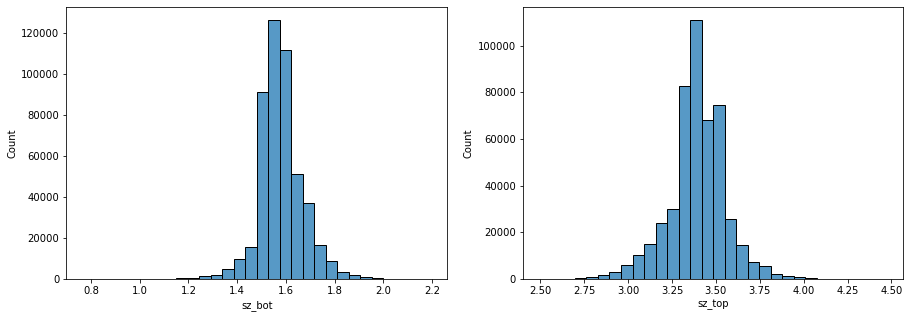

In [20]:
# plot the distribution of the bottom part of the zone for MLB pitches in scope
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(statcast_starting_pitcher_df['sz_bot'], bins = 30, ax=ax1)
sns.histplot(statcast_starting_pitcher_df['sz_top'], bins = 30, ax=ax2)

In [21]:
##### Normalize pitch height location to league average -----

# calculate the middle part of batter zone
statcast_starting_pitcher_df['sz_mid'] = (statcast_starting_pitcher_df['sz_bot'] + statcast_starting_pitcher_df['sz_top'])/2

# calculate the average bottom part of zone
sz_bot_avg = statcast_starting_pitcher_df['sz_bot'].mean()

# calculate the average top part of zone
sz_top_avg = statcast_starting_pitcher_df['sz_top'].mean()

# calculate the average middle part of zone
sz_mid_avg = statcast_starting_pitcher_df['sz_mid'].mean()

print("The average bottom part of the zone is:", sz_bot_avg)
print("The average middle part of the zone is:", sz_mid_avg)
print("The average top part of the zone is:", sz_top_avg)

# normalize the pitch height to the league average relative to the batter's height
#   1. determine distance from pitch to middle of zone
#   2. divide by distance from bottom/top of zone to middle of zone
#   3. multiply units from middle by league average
#   4. add the league average middle of zone
statcast_starting_pitcher_df['plate_z_norm'] = (statcast_starting_pitcher_df['plate_z'] - statcast_starting_pitcher_df['sz_mid']) /  \
                                               (statcast_starting_pitcher_df['sz_mid'] - statcast_starting_pitcher_df['sz_bot']) *  \
                                               (sz_mid_avg-sz_bot_avg) +  \
                                               sz_mid_avg

The average bottom part of the zone is: 1.574895560522476
The average middle part of the zone is: 2.4844558951910996
The average top part of the zone is: 3.394016229859721


### Batted Ball Type

Batted ball type is listed as a number index and we are going to alter it to a category representation.

In [22]:
# label batted ball type
statcast_starting_pitcher_df['batted_ball_type'] = np.where(statcast_starting_pitcher_df['launch_speed_angle'] == 1, 'Weak',
                                                   np.where(statcast_starting_pitcher_df['launch_speed_angle'] == 2, 'Topped',
                                                   np.where(statcast_starting_pitcher_df['launch_speed_angle'] == 3, 'Under',
                                                   np.where(statcast_starting_pitcher_df['launch_speed_angle'] == 4, 'Flare/Burner',
                                                   np.where(statcast_starting_pitcher_df['launch_speed_angle'] == 5, 'Solid Contact',
                                                   np.where(statcast_starting_pitcher_df['launch_speed_angle'] == 6, 'Barrel', 
                                                   statcast_starting_pitcher_df['launch_speed_angle']))))))

### Event Reformatting

Going to change the text format for the event name.

In [23]:
# reformat events field
statcast_starting_pitcher_df['events'] = statcast_starting_pitcher_df['events'].str.replace("_", " ").str.capitalize()

### Next Pitch Count

Getting the next pitch count to enable pitch count flow visual.

In [24]:
# get the next count in atbats
statcast_starting_pitcher_df['lead_count'] = statcast_starting_pitcher_df.sort_values(['pitcher_name', 'game_pk','at_bat_number','pitch_number']).groupby(['game_pk','at_bat_number'])['count'].shift(-1)

## Save output

The training, validation, and test data sets will be used throughout the model building process. There will be several models attempted. The data sets need to be consistent across model runs. These files will be referenced throughout the model notebooks for training, tuning, and evaluating models.

In [25]:
##### Save the prepped data ----

# Save data
statcast_starting_pitcher_df.to_csv(os.path.join(DATA_DIR, f'pitch_data.csv'), sep=';', index = None, header = True)